In [16]:
from gerrychain import Graph

# read West Virginia county graph from the json file "WV_county.json"
filename = 'WV_county.json'

# use built-in GerryChain function to read graph
G = Graph.from_json( filename )

In [2]:
# for each node, print the node #, county name, population and lat-long coordinates
for node in G.nodes:
    name = G.nodes[node]['NAME20']
    population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = population
    
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20'] # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20'] # latitude of county's center
    
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",G.nodes[node]['C_X'],",",G.nodes[node]['C_Y'],")")

Node 0 is Wyoming County, which has population 21382 and is centered at ( -081.5490317 , +37.6036601 )
Node 1 is Braxton County, which has population 12447 and is centered at ( -080.7316597 , +38.6993304 )
Node 2 is Roane County, which has population 14028 and is centered at ( -081.3544939 , +38.7429497 )
Node 3 is Grant County, which has population 10976 and is centered at ( -079.1950640 , +39.1059882 )
Node 4 is Monroe County, which has population 12376 and is centered at ( -080.5503295 , +37.5540622 )
Node 5 is Doddridge County, which has population 7808 and is centered at ( -080.7114979 , +39.2643068 )
Node 6 is Wirt County, which has population 5194 and is centered at ( -081.3829749 , +39.0200337 )
Node 7 is Tyler County, which has population 8313 and is centered at ( -080.8772193 , +39.4656340 )
Node 8 is Greenbrier County, which has population 32977 and is centered at ( -080.4505897 , +37.9244177 )
Node 9 is Ritchie County, which has population 8444 and is centered at ( -081.066

In [3]:
# impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 2          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print( "Using L =",L,"and U =",U,"and k =",k )

Using L = 892374 and U = 901342 and k = 2


In [4]:
# create distance dictionary
from geopy.distance import geodesic

dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'],G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'],G.nodes[j]['C_X'] )
        dist[i,j] = geodesic( loc_i,loc_j ).miles

In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model
m = gp.Model()

# create x[i,j] variable which equals one when county i is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-22


In [6]:
# set objective to minimize the moment of inertia
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [8]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

# add flow variables
f = m.addVars( DG.edges, G.nodes ) # f[i,j,v] = flow across arc (i,j) that is sent from root v

# add constraints saying that if node i is assigned to node j, then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can recieve flow of type j only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i!= j )

# add constraints saying that node j cannot recieve flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [9]:
# solve, with a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 9186 rows, 16775 columns and 61760 nonzeros
Model fingerprint: 0x67732ac5
Variable types: 13750 continuous, 3025 integer (3025 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+05]
  Objective range  [1e+06, 8e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 536 rows and 930 columns
Presolve time: 0.22s
Presolved: 8650 rows, 15845 columns, 59411 nonzeros
Variable types: 12769 continuous, 3076 integer (3025 binary)

Root relaxation: objective 5.221255e+09, 1629 iterations, 0.09 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

In [10]:
# print the objective value
print('The objective value is =',m.objVal)
print('')

# retrieve the district "centers"
centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k) ]
district_populations = [ sum( G.nodes[i]["TOTPOP"] for i in districts[j] ) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

# print deviation between districts
print("The deviation between the districts is",abs( district_populations[0]-district_populations[1] ),"persons." )

The objective value is = 5319444696.425297

District 0 has population 899947 and contains counties ['Wyoming', 'Roane', 'Monroe', 'Summers', 'Raleigh', 'Nicholas', 'Mason', 'Calhoun', 'Lincoln', 'Kanawha', 'Mingo', 'Wayne', 'Putnam', 'Boone', 'Cabell', 'Jackson', 'Wood', 'McDowell', 'Clay', 'Logan', 'Fayette', 'Mercer']

District 1 has population 893769 and contains counties ['Braxton', 'Grant', 'Doddridge', 'Wirt', 'Tyler', 'Greenbrier', 'Ritchie', 'Randolph', 'Marion', 'Pendleton', 'Berkeley', 'Upshur', 'Taylor', 'Gilmer', 'Brooke', 'Ohio', 'Morgan', 'Lewis', 'Pocahontas', 'Wetzel', 'Marshall', 'Monongalia', 'Mineral', 'Hancock', 'Preston', 'Hardy', 'Webster', 'Hampshire', 'Harrison', 'Barbour', 'Tucker', 'Pleasants', 'Jefferson']

The deviation between the districts is 6178 persons.


In [12]:
# read West Virginia shapefile from "WV_county.shp" to draw it on a map
import geopandas as gpd

filename = 'WV_county.shp'

# read geopandas dataframe from file
df = gpd.read_file( filename )

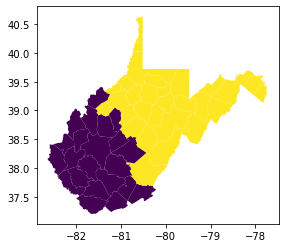

In [13]:
# county i is assigned to district j
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j


# add the assignments to a column of the dataframe and map it
node_with_this_geoid = {G.nodes[i]['GEOID20'] : i for i in G.nodes}

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given the same district # that county i has in 'labeling'
    assignment[u] = labeling[i] 

# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()